In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import os

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [2]:
# load your dataset
data_dir = os.path.join(os.getcwd(), 'data_files')

target_df = pd.read_csv(os.path.join(data_dir, 'targets.csv'), parse_dates=['USAGE_DATE'], index_col='USAGE_DATE')
predictor_df = pd.read_csv(os.path.join(data_dir, 'predictors.csv'), parse_dates=['USAGE_DATE'], index_col='USAGE_DATE')
predictor_df['Holiday'] = predictor_df['Holiday'].astype(int)

df = target_df.join(predictor_df).sort_index(ascending=True)

In [3]:
df_test = df[df.index >= pd.to_datetime('3/15/21')] 
df_train = df[df.index < pd.to_datetime('3/15/21')]

In [ ]:
# Simple exponential smoothing
forecast_days = 5
forecast_dates = pd.date_range(start=df.index.max(), end=df.index.max()+pd.DateOffset(days=forecast_days))[1:]

# exponential smoothing requires sorting dates with latest at the bottom!!!!
fit1 = ExponentialSmoothing(df['SoCal_TOTAL'], initialization_method="heuristic").fit(smoothing_level=0.2,optimized=False)
fit2 = ExponentialSmoothing(df['SoCal_TOTAL'], initialization_method="heuristic").fit(smoothing_level=0.6,optimized=False)
fit3 = ExponentialSmoothing(df['SoCal_TOTAL'], initialization_method="estimated").fit()

fit_df = pd.DataFrame({'SES_0.2':fit1.fittedvalues, 
                       'SES_0.6': fit2.fittedvalues, 
                       'SES_' +str(fit3.model.params['smoothing_level']): fit3.fittedvalues})

forecast_df = pd.DataFrame({'USAGE_DATE': forecast_dates, 
                            'SES_0.2':fit1.forecast(forecast_days),
                            'SES_0.6': fit2.forecast(forecast_days), 
                            'SES_' +str(fit3.model.params['smoothing_level']): fit3.forecast(forecast_days)}).set_index('USAGE_DATE')

plt.figure(figsize=(10, 7))
plt.rcParams.update({'font.size': 12})
sns.lineplot(data=fit_df, legend=True)
sns.lineplot(data=df, x=df.index, y='SoCal_TOTAL', color='k', legend=True)
sns.lineplot(data=forecast_df, legend=False)
plt.xticks(rotation=45), plt.xlim([fit_df.index.max() - pd.DateOffset(months=1), forecast_df.index.max()])
plt.ylabel('MDth')
plt.show()

In [ ]:
# Holt's linear trend with additive/multiplicative damping
forecast_days = 20
forecast_dates = pd.date_range(start = df_train.index.max(), end = df_train.index.max()+pd.DateOffset(days=forecast_days))[1:]

ses = ExponentialSmoothing(df_train['SoCal_TOTAL'], initialization_method="estimated").fit()
holt1 = Holt(df_train['SoCal_TOTAL'], initialization_method="estimated").fit()
holt2 = Holt(df_train['SoCal_TOTAL'], exponential=True, initialization_method="estimated").fit()
holt3 = Holt(df_train['SoCal_TOTAL'], damped_trend=True, initialization_method="estimated").fit(damping_trend=0.98)
holt4 = Holt(df_train['SoCal_TOTAL'], exponential=True, damped_trend=True, initialization_method="estimated").fit()


holt_df = pd.DataFrame({'USAGE_DATE': df_train.index,
                        'SES': ses.fittedvalues,
                        'Holt linear': holt1.fittedvalues, 
                        'Exponential trend': holt2.fittedvalues, 
                        'Additive damped': holt3.fittedvalues,
                        'Multiplicative damped': holt4.fittedvalues})

holt_fcst_df = pd.DataFrame({'USAGE_DATE': forecast_dates, 
                             'SES': ses.forecast(forecast_days),
                             'Holt linear':holt1.forecast(forecast_days),
                             'Exponential': holt2.forecast(forecast_days), 
                             'Additive damped': holt3.forecast(forecast_days),
                             'Multiplicative damped': holt4.forecast(forecast_days)}).set_index('USAGE_DATE')


plt.figure(figsize=(10, 7))
plt.rcParams.update({'font.size': 12})
sns.lineplot(data=holt_df, legend=True)
sns.lineplot(data=df_train, x=df_train.index, y='SoCal_TOTAL', color='k', legend=True)
sns.lineplot(data=holt_fcst_df, legend=False)
sns.lineplot(data=df_test, x=df_test.index, y='SoCal_TOTAL', color='k', legend=True)
plt.xticks(rotation=45), plt.xlim([holt_df.index.max() - pd.DateOffset(months=1), holt_fcst_df.index.max()])
plt.ylabel('MDth')
plt.show()

C:\Users\JCheung1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\JCheung1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\JCheung1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\JCheung1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


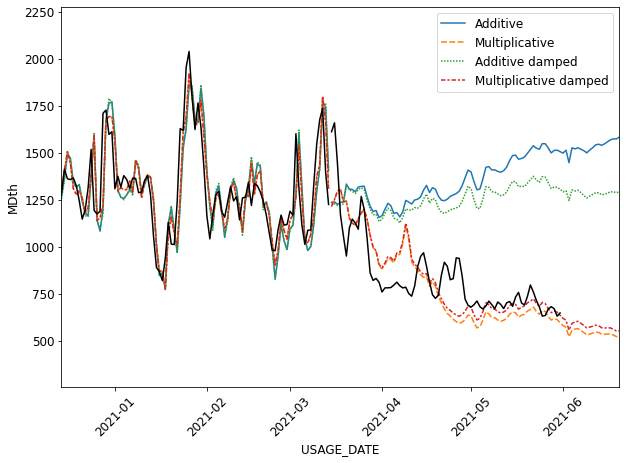

In [4]:
# Exponential smoothing with additive/multiplicative seasonality, trend, and additive trend
forecast_days = 20
forecast_dates = pd.date_range(start = df_train.index.max(), end = df_test.index.max()+pd.DateOffset(days=forecast_days))[1:]

seasonal1= ExponentialSmoothing(df_train['SoCal_TOTAL'], seasonal_periods=365, seasonal='add', trend='add', initialization_method="estimated").fit()
seasonal2 = ExponentialSmoothing(df_train['SoCal_TOTAL'], seasonal_periods=365, seasonal='mul', trend='add', initialization_method="estimated").fit()
seasonal3 = ExponentialSmoothing(df_train['SoCal_TOTAL'], seasonal_periods=365, seasonal='add', damped_trend=True, trend='add', initialization_method="estimated").fit()
seasonal4 = ExponentialSmoothing(df_train['SoCal_TOTAL'], seasonal_periods=365, seasonal='mul', damped_trend=True, trend='add', initialization_method="estimated").fit()

seasonal_df = pd.DataFrame({'USAGE_DATE': df_train.index,
                        'Additive': seasonal1.fittedvalues,
                        'Multiplicative': seasonal2.fittedvalues, 
                        'Additive damped': seasonal3.fittedvalues, 
                        'Multiplicative damped': seasonal4.fittedvalues})

seasonal_fcst_df = pd.DataFrame({'USAGE_DATE': forecast_dates, 
                             'Additive': seasonal1.forecast(len(forecast_dates)),
                             'Multiplicative':seasonal2.forecast(len(forecast_dates)),
                             'Additive damped': seasonal3.forecast(len(forecast_dates)), 
                             'Multiplicative damped': seasonal4.forecast(len(forecast_dates))}).set_index('USAGE_DATE')


plt.figure(figsize=(10, 7))
plt.rcParams.update({'font.size': 12})
sns.lineplot(data=seasonal_df, legend=True)
sns.lineplot(data=df_train, x=df_train.index, y='SoCal_TOTAL', color='k', legend=True)
sns.lineplot(data=seasonal_fcst_df, legend=False)
sns.lineplot(data=df_test, x=df_test.index, y='SoCal_TOTAL', color='k', legend=True)
plt.xticks(rotation=45), plt.xlim([seasonal_df.index.max() - pd.DateOffset(months=3), seasonal_fcst_df.index.max()])
plt.ylabel('MDth')
plt.show()

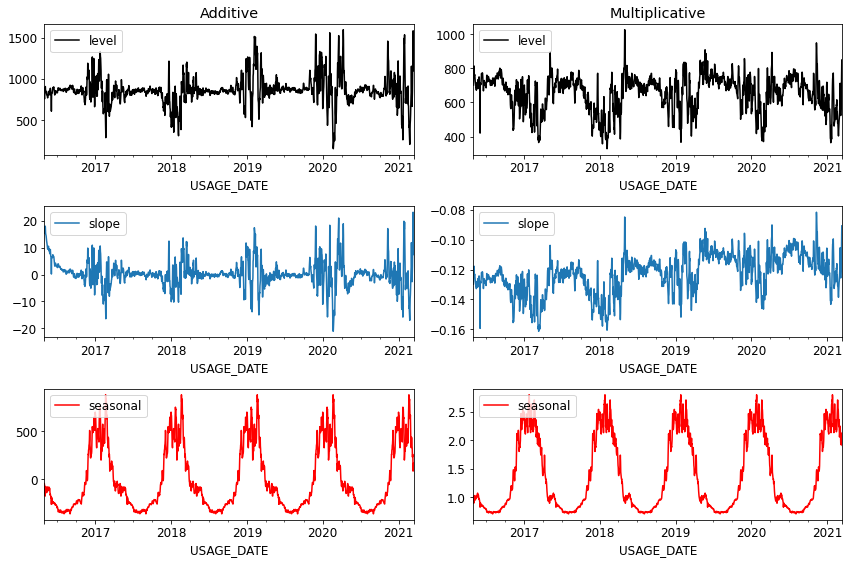

(None, None)

In [5]:
states1 = pd.DataFrame(np.c_[seasonal1.level, seasonal1.trend, seasonal1.season], columns=['level','slope','seasonal'], index=df_train.index)
states2 = pd.DataFrame(np.c_[seasonal2.level, seasonal2.trend, seasonal2.season], columns=['level','slope','seasonal'], index=df_train.index)
fig, [[ax1, ax4],[ax2, ax5], [ax3, ax6]] = plt.subplots(3, 2, figsize=(12,8))
states1[['level']].plot(ax=ax1, color='k'), ax1.set_title('Additive')
states1[['slope']].plot(ax=ax2)
states1[['seasonal']].plot(ax=ax3, color='r')
states2[['level']].plot(ax=ax4, color='k'), ax4.set_title('Multiplicative')
states2[['slope']].plot(ax=ax5)
states2[['seasonal']].plot(ax=ax6, color='r')
plt.tight_layout(), plt.show()

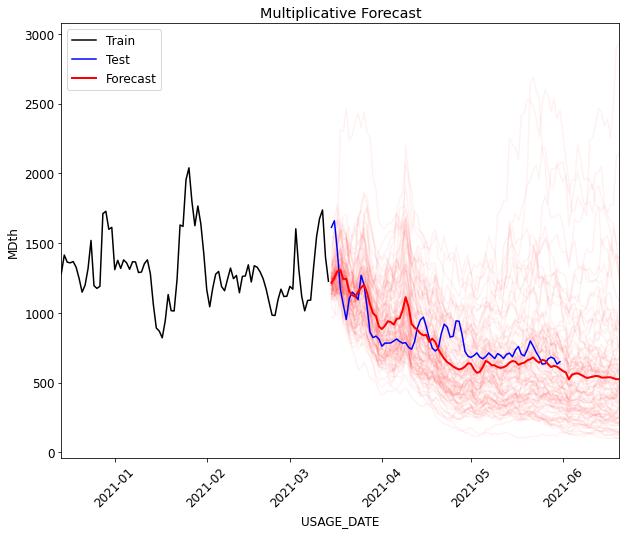

In [6]:
simulations = seasonal2.simulate(len(forecast_dates), anchor=df_test.index.min(), repetitions=100, error='mul', random_errors='bootstrap')
plt.figure(figsize=(10,8))
plt.plot(simulations, c='r', alpha=0.05)
plt.plot(df_train['SoCal_TOTAL'], c='k', label='Train')
plt.plot(df_test['SoCal_TOTAL'], c='b', label='Test')
plt.plot(seasonal_fcst_df['Multiplicative'],c='r', linewidth=2, label='Forecast')
plt.xticks(rotation=45), plt.xlim([seasonal_df.index.max() - pd.DateOffset(months=3), seasonal_fcst_df.index.max()])
plt.xlabel('USAGE_DATE'), plt.ylabel('MDth'), plt.title('Multiplicative Forecast')
plt.legend(loc='upper left')
plt.show()

In [20]:
def rmse(residuals):
    return np.sqrt(np.mean(residuals**2))

def mae(residuals):
    return np.mean(np.abs(residuals))

seasonal1.test_resid = seasonal1.forecast(len(forecast_dates)) - df_test['SoCal_TOTAL']
seasonal2.test_resid = seasonal2.forecast(len(forecast_dates)) - df_test['SoCal_TOTAL']
seasonal3.test_resid = seasonal3.forecast(len(forecast_dates)) - df_test['SoCal_TOTAL']
seasonal4.test_resid = seasonal4.forecast(len(forecast_dates)) - df_test['SoCal_TOTAL']


evaluation_df = pd.DataFrame({'RMSE_train': [rmse(seasonal1.resid), rmse(seasonal2.resid), rmse(seasonal3.resid), rmse(seasonal4.resid)],
                              'MAE_train': [mae(seasonal1.resid), mae(seasonal2.resid), mae(seasonal3.resid), mae(seasonal4.resid)],
                              'RMSE_test': [rmse(seasonal1.test_resid), rmse(seasonal2.test_resid), rmse(seasonal3.test_resid), rmse(seasonal4.test_resid)],
                              'MAE_test': [mae(seasonal1.test_resid), mae(seasonal2.test_resid), mae(seasonal3.test_resid), mae(seasonal4.test_resid)],
                              'aic': [seasonal1.aic, seasonal2.aic, seasonal3.aic, seasonal4.aic],
                              'aicc': [seasonal1.aicc, seasonal2.aicc, seasonal3.aicc, seasonal4.aicc],
                              'bic': [seasonal1.bic, seasonal2.bic, seasonal3.bic, seasonal4.bic]}, 
                             index=['Additive', 'Multiplicative', 'Additive damped', 'Multiplicative damped']).transpose()

print(evaluation_df)
evaluation_df.idxmin(axis=1)
# select Multiplicative additive damped model 

                Additive  Multiplicative  Additive damped  \
RMSE_train     83.230915       77.785121        83.483248   
MAE_train      50.122948       46.889528        49.840354   
RMSE_test     572.094389      151.384455       478.927117   
MAE_test      526.434175      119.504654       447.159539   
aic         16470.119897    16229.354672     16482.890414   
aicc        16666.299002    16425.533777     16680.267369   
bic         18493.644565    18252.879340     18511.898888   

            Multiplicative damped  
RMSE_train              77.740772  
MAE_train               46.840459  
RMSE_test              142.924637  
MAE_test               102.882174  
aic                  16229.325531  
aicc                 16426.702487  
bic                  18258.334005  


RMSE_train    Multiplicative damped
MAE_train     Multiplicative damped
RMSE_test     Multiplicative damped
MAE_test      Multiplicative damped
aic           Multiplicative damped
aicc                 Multiplicative
bic                  Multiplicative
dtype: object